In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt

In [46]:
def bernoulli_KL(x,y):
    if (x == 0 or y == 0 or x == 1 or y == 1):
        return 0
    
    return x*np.log(x/y) + (1-x)*np.log((1-x)/(1-y))

In [25]:
def lower_bound(p1, p2, delta):
    D_star = bernoulli_KL(p1, (p1 + p2)/2) + bernoulli_KL(p2, (p1 + p2)/2)
    return np.log(1/(2.4*delta))/D_star

In [26]:
def PPR_criteria(n_fact, s1_fact, s2_fact, f1_fact, f2_fact, n, s1n, s2n, f1n, f2n, delta):
    
    if any(x <= 0 for x in [n_fact, s1_fact, s2_fact, f1_fact, f2_fact, s1n + s2n, f1n + f2n, delta]):
        return False
    
    return (
        math.log(s1_fact) + math.log(s2_fact) + math.log(f1_fact) + math.log(f2_fact)
        - 2 * math.log(n_fact * (n + 1))
        - (s1n + s2n) * math.log(s1n + s2n)
        - (f1n + f2n) * math.log(f1n + f2n)
        + 2 * n * math.log(2 * n) > math.log(1 / delta)
    )

In [27]:
def UCNF_criteria(n, mu_hat1, mu_hat2, delta):
    beta = np.log((4*n)/delta)
    D_star = bernoulli_KL(mu_hat1, (mu_hat1 + mu_hat2)/2) + bernoulli_KL(mu_hat2, (mu_hat1 + mu_hat2)/2)
    if mu_hat1 > mu_hat2:
        if (n*D_star > beta):
            return 1
    else:
        if (n*D_star > beta):
            return 2
        
    return 0

In [28]:
def PPR_algorithm(p1, p2, delta):
    n = 1
    n_fact = 1
    s1_fact = 1
    s2_fact = 1
    f1_fact = 1
    f2_fact = 1
    s1n = s2n = f1n = f2n = 0

    if (np.random.binomial(n=1, p=p1, size=1) == 1):
        s1n += 1
    else:
        f1n += 1

    if (np.random.binomial(n=1, p=p2, size=1) == 1):
        s2n += 1
    else:
        f2n += 1


    while not(PPR_criteria(n_fact, s1_fact, s2_fact, f1_fact, f2_fact, n, s1n, s2n, f1n, f2n, delta)):
        
        if (np.random.binomial(n=1, p=p1, size=1) == 1):
            s1n += 1
            s1_fact *= s1n
        else:
            f1n += 1
            f1_fact *= f1n

        if (np.random.binomial(n=1, p=p2, size=1) == 1):
            s2n += 1
            s2_fact *= s2n
        else:
            f2n += 1
            f2_fact *= f2n
        
        n += 1
        n_fact *= n

    mu_hat1 = s1n / (s1n + f1n) if (s1n + f1n) > 0 else 0
    mu_hat2 = s2n / (s2n + f2n) if (s2n + f2n) > 0 else 0

    best_arm = 1 if mu_hat1 > mu_hat2 else 2
    return best_arm, n

In [29]:
def UCNF_algorithm(p1,p2,delta):
    n = 1
    mu_hat1_cummulative = np.random.binomial(n=1, p=p1, size=1)
    mu_hat2_cummulative = np.random.binomial(n=1, p=p2, size=1)

    mu_hat1 = mu_hat1_cummulative/n
    mu_hat2 = mu_hat2_cummulative/n

    while (UCNF_criteria(n, mu_hat1, mu_hat2, delta) == 0):
        mu_hat1_cummulative+=  np.random.binomial(n=1, p=p1, size=1)
        mu_hat1 = mu_hat1_cummulative/(n+1)

        mu_hat2_cummulative+=  np.random.binomial(n=1, p=p2, size=1)
        mu_hat2 = mu_hat2_cummulative/(n+1)
        n+=1
    return UCNF_criteria(n, mu_hat1, mu_hat2, delta), n

In [60]:
p1 = 0.7; p2 = 0.3
DELTA = [1e-10, 1e-20, 1e-40, 1e-60, 1e-80, 1e-100, 1e-150, 1e-175, 1e-200]
PPR = []
UCNF = []
LB = []

for delta in DELTA:
    LB_avg = 0
    PPR_avg = 0
    UCNF_avg = 0
    for i in range(200):
        LB_avg += lower_bound(p1,p2,delta)
        PPR_avg += PPR_algorithm(p1,p2,delta)[1]
        UCNF_avg += UCNF_algorithm(p1,p2,delta)[1]
    LB.append(LB_avg/200)
    PPR.append(PPR_avg/200)
    UCNF.append(UCNF_avg/200)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


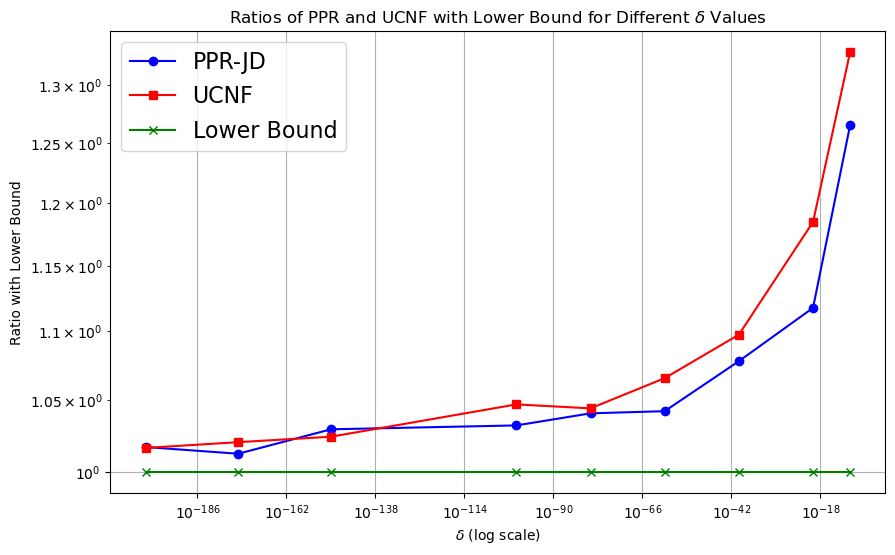

In [67]:
# Calculate the ratios
ppr_lower_bound_ratio = np.array(PPR) / np.array(LB)
ucnf_lower_bound_ratio = np.array(UCNF) / np.array(LB)
lower_bound_ratio = np.array(LB) / np.array(LB)

# Plot the PPR/LowerBound ratio
plt.figure(figsize=(10, 6))
plt.plot(DELTA, ppr_lower_bound_ratio, marker='o', linestyle='-', color='blue', label='PPR-JD')
plt.plot(DELTA, ucnf_lower_bound_ratio, marker='s', linestyle='-', color='red', label='UCNF')
plt.plot(DELTA, lower_bound_ratio, marker='x', linestyle='-', color='green', label='Lower Bound')
plt.xlabel(r"$\delta$ (log scale)")
plt.ylabel("Ratio with Lower Bound")
plt.title("Ratios of PPR and UCNF with Lower Bound for Different $\delta$ Values")
plt.xscale("log")
plt.yscale("log")
plt.legend(fontsize=16)
plt.grid(True)
plt.savefig('plot.eps')
plt.show()